In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ruptures as rpt
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf

from ruptures import Binseg, Pelt, Window

#TCN-autoencoder javítása

In [2]:
ecg_dataset = pd.read_csv('ecg.csv', header=None)
microsoft_stocks_dataset = pd.read_csv('Microsoft_Stock.csv')
month_value_dataset = pd.read_csv('Month_Value_1.csv')
yahoo_stocks_dataset = pd.read_csv('yahoo_stock.csv')

ecg_columns = [f'ECG_{i+1}' for i in range(140)]
ecg_dataset.columns = ecg_columns + ['label']

yahoo_stocks_dataset['Date'] = pd.to_datetime(yahoo_stocks_dataset['Date'])

In [3]:
month_value_dataset.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

<Axes: >

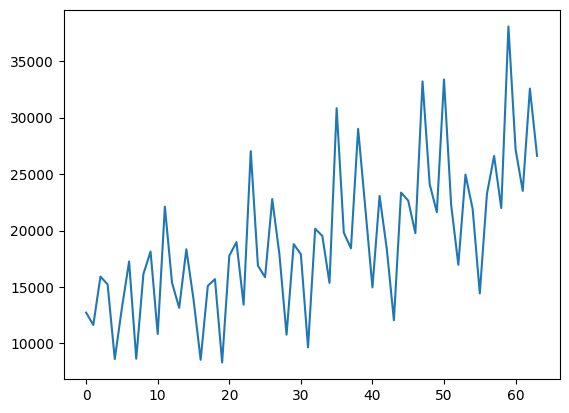

In [4]:
month_value_dataset['Sales_quantity'].plot()

In [5]:
microsoft_stocks_dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<Axes: >

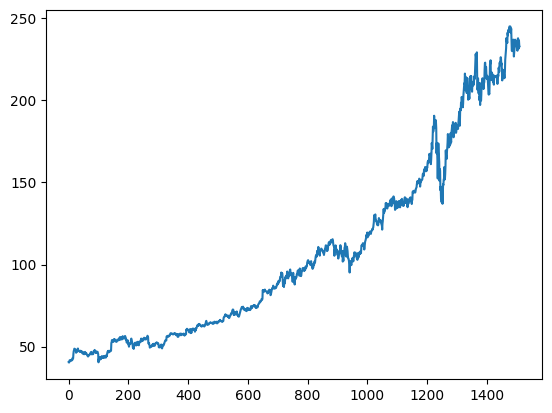

In [6]:
microsoft_stocks_dataset['Open'].plot()

<Axes: >

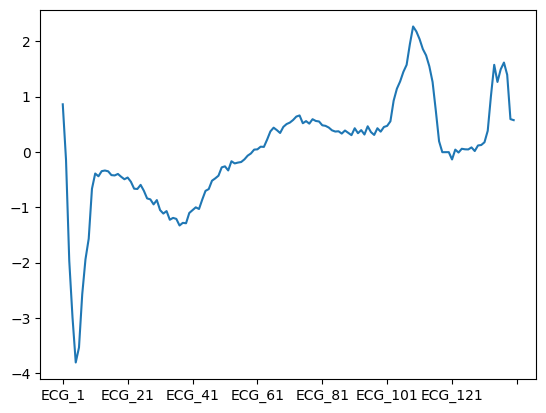

In [7]:
ecg_dataset.loc[40, ecg_columns].plot()

In [8]:
yahoo_stocks_dataset.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

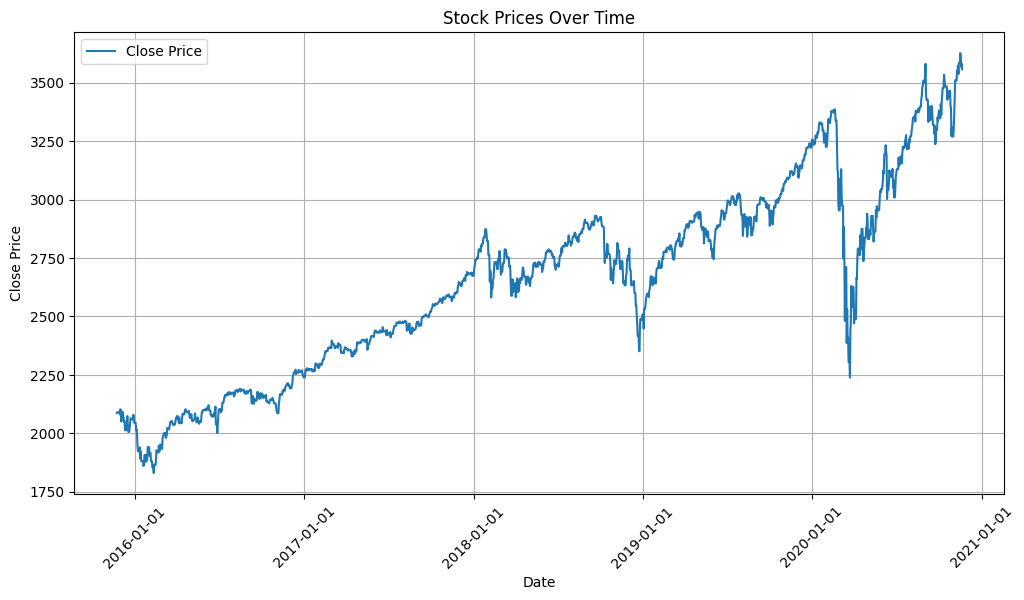

In [9]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(yahoo_stocks_dataset['Date'], yahoo_stocks_dataset['Close'], label="Close Price")

# Format the x-axis to show some dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically chooses a good interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD

# Rotate dates for better visibility
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [155]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset, load_has_dataset
from time_series_segmentation_benchmark.tssb.utils import load_time_series_segmentation_datasets
from time_series_segmentation_benchmark.tssb.evaluation import covering, f_measure

In [158]:
from tqdm import tqdm

def calculate_score(dataset, algorithm):
    score_sum = 0
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        ts_name = row['dataset']
        window_size = row['window_size']
        cps = row['change_points']
        ts = row['time_series']
        
        found_cps = algorithm(ts)
        score = covering({0: cps}, found_cps, ts.shape[0])
        score_sum += score
    return score_sum / len(dataset)

def calculate_weighted_f1(dataset, algorithm):
    weighted_score_sum = 0
    total_weight = 0
    
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        ts_name = row['dataset']
        window_size = row['window_size']
        cps = row['change_points']
        ts = row['time_series']
        
        found_cps = algorithm(ts)
        score = f_measure({0: cps}, found_cps, ts.shape[0])
        
        weight = len(ts)
        weighted_score_sum += score * weight
        total_weight += weight

    return weighted_score_sum / total_weight if total_weight > 0 else 0

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >,
       <Axes: xlabel='split point', ylabel='ClaSP Score'>], dtype=object)

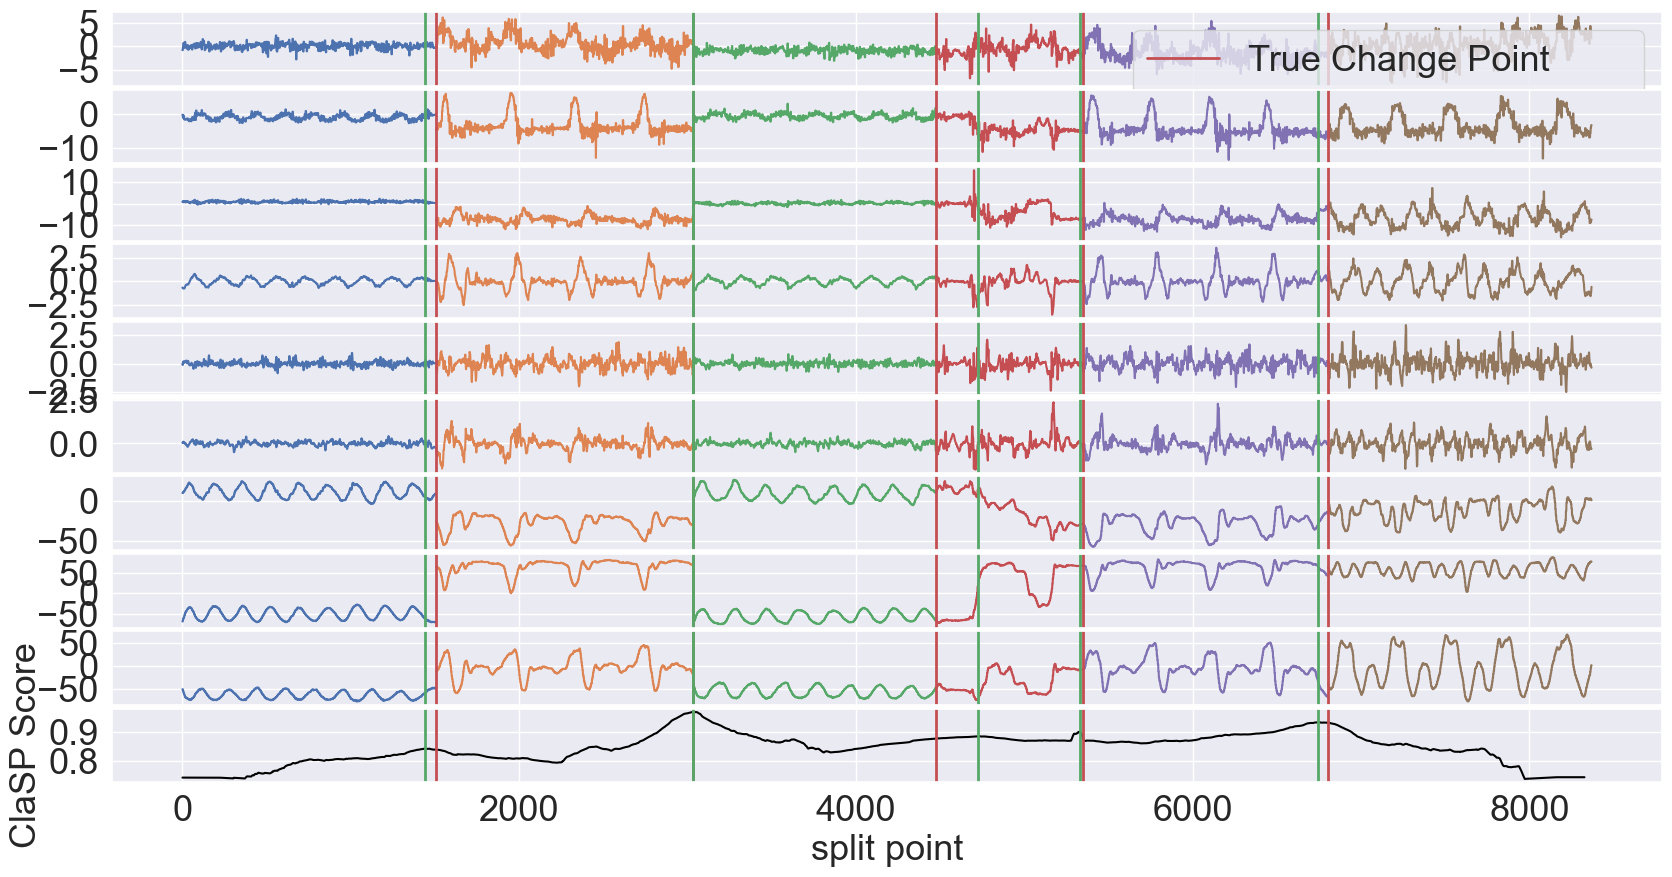

In [12]:
dataset, window_size, true_cps,labels, time_series = load_has_dataset().iloc[4,:]
clasp = BinaryClaSPSegmentation()
clasp.fit_predict(time_series)
clasp.plot(gt_cps=true_cps, file_path="segmentation_example.png")

In [12]:
tssb = load_time_series_segmentation_datasets()

has = load_has_dataset()
has.columns = ['dataset', 'window_size', 'change_points', 'labels','time_series']

In [13]:
def CLaSP_segmenter(ts):
    clasp = BinaryClaSPSegmentation()
    clasp.fit_predict(ts)
    return clasp.change_points

In [15]:
calculate_score(has.iloc[:10], CLaSP_segmenter)

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


0.6856879959036984

In [107]:
def plot_changepoints_on_ts(ts, cps, title, real_cps):
    plt.figure(figsize=(10, 4))
    plt.plot(ts)
    for cp in cps:
        plt.axvline(cp, color='red')
    for cp in real_cps:
        plt.axvline(cp, color='green')
    plt.title(title)
    plt.show()

# Change point detection

In [15]:
ecg_data = ecg_dataset[ecg_columns].values

In [16]:
# Select first ECG signal (Row 0)
which_row = 30
#ecg_signal = ecg_data[which_row]
ecg_signal = np.array(microsoft_stocks_dataset['Open'])  # Change index to analyze another row

# Apply change point detection (Pelt Algorithm with L2 cost)
algo = rpt.Pelt(model="l2").fit(ecg_signal.reshape(-1, 1))
change_points = algo.predict(pen=3000)  # Adjust 'pen' for more/less segmentation

# Print detected change points
print("Change Points Detected:", change_points)


Change Points Detected: [145, 395, 520, 650, 795, 995, 1055, 1165, 1215, 1235, 1265, 1315, 1465, 1511]


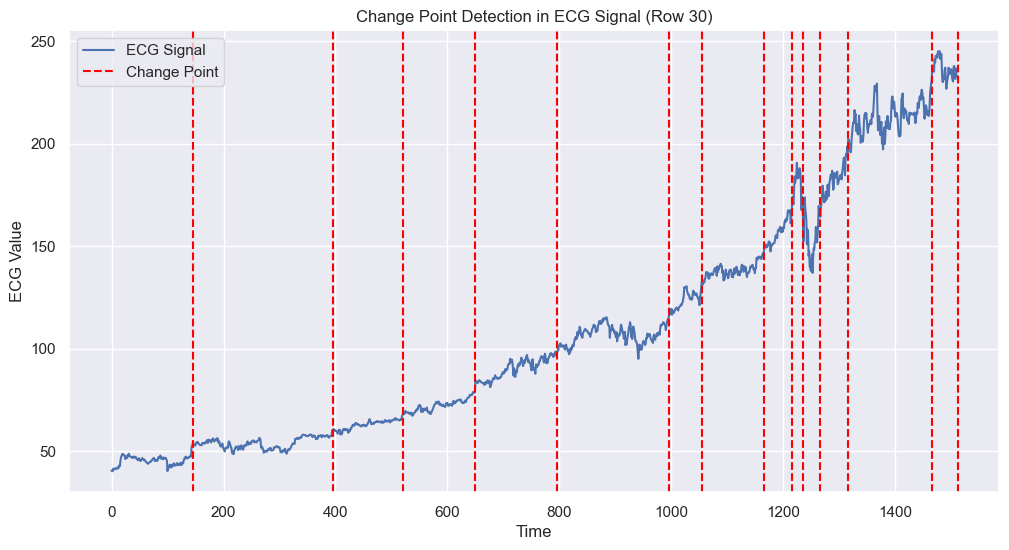

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")

# Mark detected change points
for cp in change_points:
    plt.axvline(x=cp, color='red', linestyle='--', label="Change Point" if cp == change_points[0] else "")

plt.legend()
plt.title("Change Point Detection in ECG Signal (Row " + str(which_row) + ")")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.show()


# KMeans

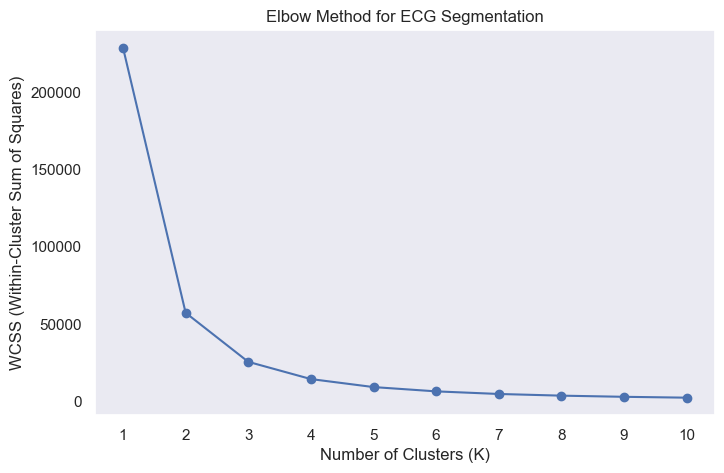

In [18]:
from sklearn.cluster import KMeans

which_row = 0

# Select one ECG signal (first row, ignoring label)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Create features: (time index, ECG value)
time_steps = np.arange(len(ecg_signal)).reshape(-1, 1)
X = np.column_stack((time_steps, ecg_signal))  # Combine time & ECG values

# Apply Elbow Method to find the best K
wcss = []
K_values = range(1, 11)  # Test K from 1 to 10

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for ECG Segmentation")
plt.xticks(K_values)
plt.grid()
plt.show()

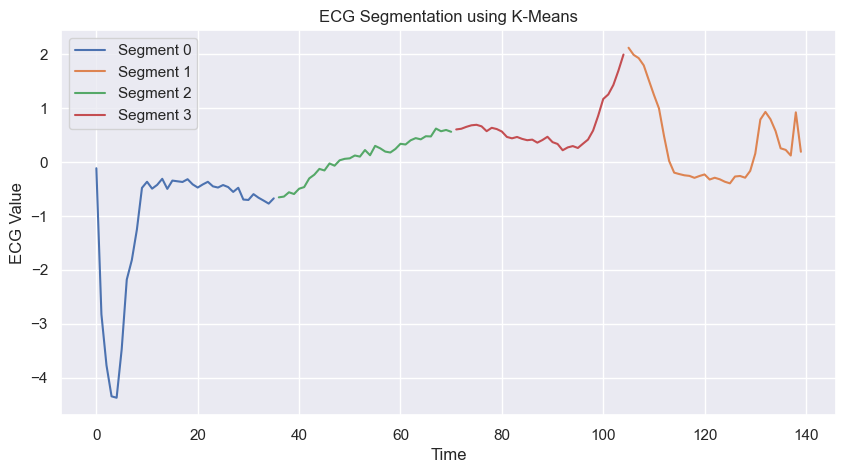

In [19]:
# Apply K-Means with the best K (replace with your best K value)
best_K = 4  # Example value, replace with the best K found from elbow method
kmeans = KMeans(n_clusters=best_K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Plot the segmented ECG signal
plt.figure(figsize=(10, 5))
for cluster in np.unique(labels):
    plt.plot(time_steps[labels == cluster], ecg_signal[labels == cluster], label=f'Segment {cluster}')

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Segmentation using K-Means")
plt.legend()
plt.show()


# Time series KMeans

In [20]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


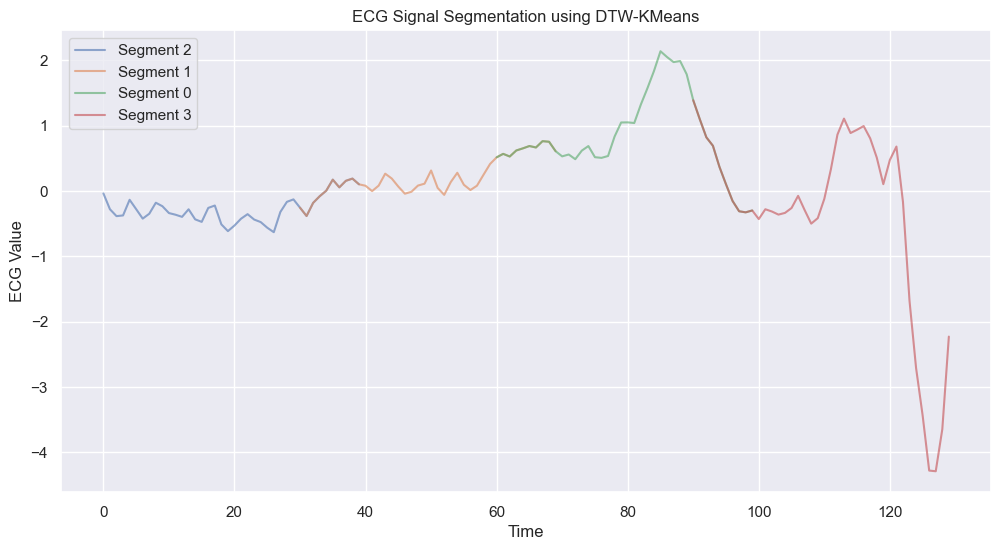

In [21]:
# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[30, :-1].values  # Assuming last column is "label"

# Define segmentation parameters
window_size = 40  # Number of points per segment
stride = 30  # Step size for segment extraction

# Create overlapping segments
segments = [ecg_signal[i:i+window_size] for i in range(0, len(ecg_signal)-window_size, stride)]
segments = np.array(segments)

# Normalize segments
segments_scaled = TimeSeriesScalerMeanVariance().fit_transform(segments)

# Apply DTW-KMeans
n_clusters = 4  # Adjust based on elbow method
dtw_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = dtw_kmeans.fit_predict(segments_scaled)

# Plot segmented ECG signal
plt.figure(figsize=(12, 6))
time_axis = np.arange(len(ecg_signal))

for i, segment_start in enumerate(range(0, len(ecg_signal)-window_size, stride)):
    plt.plot(time_axis[segment_start:segment_start+window_size], ecg_signal[segment_start:segment_start+window_size], 
             label=f"Segment {labels[i]}", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Signal Segmentation using DTW-KMeans")
plt.legend()
plt.show()

# BinarySegmentation

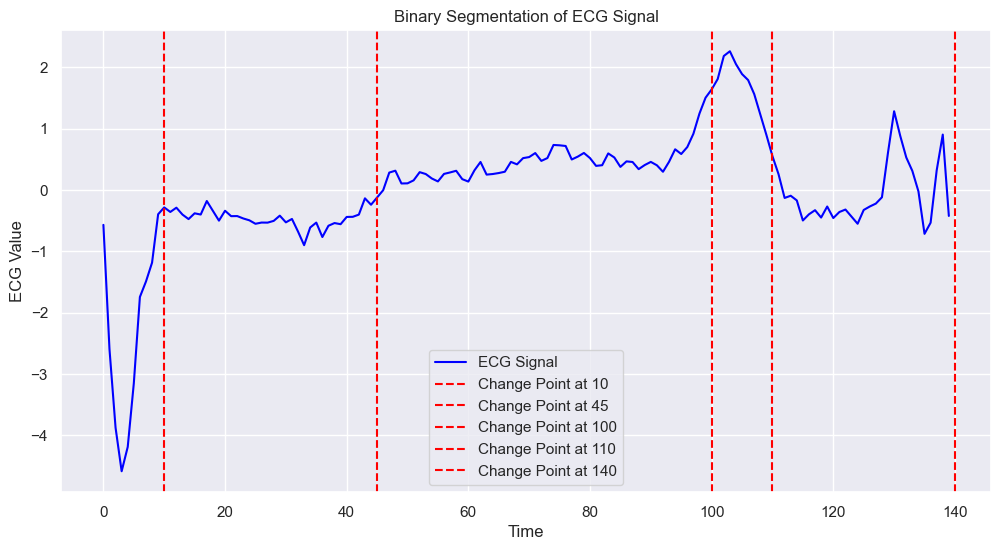

In [22]:
which_row = 2

# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Define parameters for the binary segmentation
model = "l2"  # Model used for change point detection (l2: least squares)
algo = rpt.Binseg(model=model).fit(ecg_signal)  # Binary segmentation algorithm

# Detect change points
break_points = 4  # Number of change points to detect
change_points = algo.predict(n_bkps=break_points)  # Set n_bkps=1 for one change point

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal", color="blue")
for cp in change_points:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

# TCN-based autoencoder

In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm

In [151]:
# Define TCN Autoencoder
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super(TCNBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Ensures output length matches input
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channels)


    def forward(self, x):
        return self.batch_norm(self.relu(self.conv(x)))

In [152]:
class TCN_Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(TCN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            TCNBlock(1, 16, kernel_size=3, dilation=1),
            TCNBlock(16, 32, kernel_size=3, dilation=2),
            TCNBlock(32, 8, kernel_size=3, dilation=4),
        )
        self.decoder = nn.Sequential(
            TCNBlock(8, 32, kernel_size=3, dilation=4),
            TCNBlock(32, 16, kernel_size=3, dilation=2),
            nn.Conv1d(16, 1, kernel_size=3, padding=1)  # Ensures input-output match
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [153]:
def rolling_window_error(reconstruction_error, window_size, threshold_factor):
    rolling_mean = np.convolve(reconstruction_error, np.ones(window_size) / window_size, mode='same')
    rolling_std = np.sqrt(np.convolve((reconstruction_error - rolling_mean) ** 2, 
                                      np.ones(window_size) / window_size, mode='same'))

    # Detect change points where error > rolling mean + threshold_factor * rolling std
    change_points = np.where(reconstruction_error > (rolling_mean + threshold_factor * rolling_std))[0]
    
    return change_points



def TCNAutoencoder_segmenter(signal, epochs=380, window_size=50, threshold_factor=4.0):
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,T]
    model = TCN_Autoencoder(signal.shape[-1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(signal)
        loss = criterion(output, signal)
        loss.backward()
        optimizer.step()
    
    # Compute reconstruction error
    reconstruction_error = torch.abs(output.squeeze() - signal.squeeze()).cpu().detach().numpy()

    # Detect change points using the rolling window method
    change_points = rolling_window_error(reconstruction_error, window_size, threshold_factor)

    # Get reconstructed signal
    reconstructed_signal = output.squeeze().cpu().detach().numpy()
    original_signal = signal.squeeze().cpu().detach().numpy()

    #Plot results
    # plt.figure(figsize=(10, 4))
    # plt.plot(original_signal, label="Original Signal")
    # plt.plot(reconstruction_error, label="Reconstruction Error", color='orange')
    # plt.plot(reconstructed_signal, label="Reconstructed Signal", linestyle='dashed')
    # plt.scatter(change_points, original_signal[change_points], color='red', label="Change Points")
    # plt.legend()
    # plt.title("Signal Segmentation using TCN Autoencoder with Rolling Window")
    # plt.show()

    return change_points

In [58]:
# Example usage (assuming 'ecg_df' is your dataset)
#signal = ecg_dataset.iloc[3, :-1].values
signal = np.array(microsoft_stocks_dataset['Open'])

change_points = TCNAutoencoder_segmenter(signal)
print("Detected change points:", change_points)

Detected change points: []


In [27]:
has_for_tcnautoencoder = load_has_dataset()
has_for_tcnautoencoder.columns = ['dataset', 'window_size', 'change_points', 'labels','time_series']

In [28]:
has_for_tcnautoencoder['time_series'] = has_for_tcnautoencoder['time_series'].apply(lambda x: np.array([item[0] for item in x]))
has_for_tcnautoencoder=has_for_tcnautoencoder.drop(columns=['labels'])

In [154]:
calculate_score(has_for_tcnautoencoder.iloc[0:30], TCNAutoencoder_segmenter)

100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


0.5122241316255907

In [111]:
calculate_score(has_for_tcnautoencoder.iloc[10:35], TCNAutoencoder_segmenter)

100%|██████████| 25/25 [00:43<00:00,  1.73s/it]


0.5278729380939473

# CLaSP on ecg_dataset

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


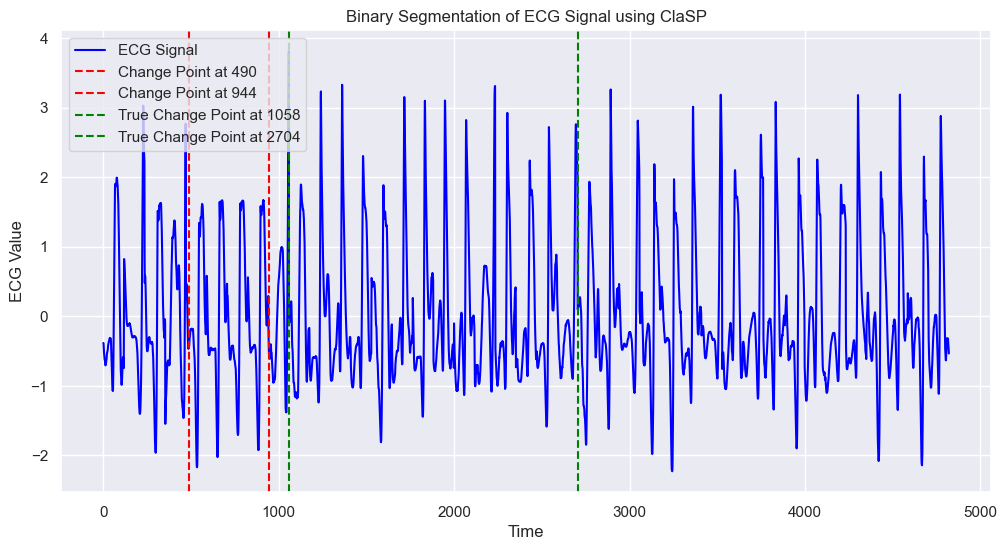

Detected change points: [490 944]


In [29]:
which_row = 34

# Select a single ECG signal (e.g., first row)
#signal = np.array(microsoft_stocks_dataset['Open'])
signal = tssb.loc[which_row, 'time_series']
found_cps = BinaryClaSPSegmentation().fit_predict(signal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(signal, label="ECG Signal", color="blue")
for cp in found_cps:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
for cp in tssb.loc[which_row, 'change_points']:
    plt.axvline(x=cp, color="green", linestyle="--", label=f"True Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal using ClaSP")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

print("Detected change points:", found_cps)



In [206]:
from scipy.cluster.hierarchy import inconsistent

def find_optimal_threshold(Z, max_depth=10):
    max_variation = 0
    best_threshold = None

    for depth in range(1, max_depth + 1):
        inconsistency = inconsistent(Z, depth)
        threshold = np.mean(inconsistency[:, 3]) + np.std(inconsistency[:, 3])
        variation = np.std(inconsistency[:, 3])

        if variation > max_variation:
            max_variation = variation
            best_threshold = threshold
    
    return best_threshold

# Modellek

In [207]:
def optimize_pelt(ts, model="l2", penalty_range=np.linspace(1, 20, 5)):
    costs = []
    n_segments = []

    for penalty in penalty_range:
        algo = rpt.Pelt(model=model, min_size=len(ts)/6).fit(ts)
        bkps = algo.predict(pen=penalty)
        
        cost = np.sum(np.diff([0] + bkps) ** 2)
        costs.append(cost)
        n_segments.append(len(bkps))

    knee = KneeLocator(penalty_range, costs, curve="convex", direction="decreasing")
    optimal_penalty = knee.knee

    return optimal_penalty if optimal_penalty != None else penalty_range.mean()

def pelt_segmenter(ts, model="l2"):
    optimal_penalty = optimize_pelt(ts, model=model)
    algo = Pelt(model=model, min_size=len(ts)/6).fit(ts)
    return algo.predict(pen=optimal_penalty)

def binseg_segmenter(ts, model="l2"):
    algo = rpt.Binseg(model=model).fit(ts)
    
    max_bkps = min(15, len(ts) // 25)  
    costs = []
    n_bkps_range = np.arange(1, max_bkps + 1)
    
    for n_bkps in n_bkps_range:
        bkps = algo.predict(n_bkps=n_bkps)
        cost = algo.cost.sum_of_costs(bkps)
        costs.append(cost)
    
    kneedle = KneeLocator(n_bkps_range, costs, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else max_bkps // 2 
    
    return algo.predict(n_bkps=optimal_bkps)

def bottomup_segmenter(ts, model="l2"):
    algo = rpt.BottomUp(model=model).fit(ts)
    
    max_bkps = min(15, len(ts) // 25)
  
    costs = []
    n_bkps_range = np.arange(1, max_bkps + 1)
    
    for n_bkps in n_bkps_range:
        bkps = algo.predict(n_bkps=n_bkps)
        cost = algo.cost.sum_of_costs(bkps)
        costs.append(cost)
    
   
    kneedle = KneeLocator(n_bkps_range, costs, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else max_bkps // 2  
    
    return algo.predict(n_bkps=optimal_bkps)

def window_segmenter(ts, model="l2", width=None):
    ts = np.array(ts)  

   
    if width is None:
        width = max(5, len(ts) // 20)  

    algo = Window(model=model, width=width).fit(ts)

    
    max_bkps = min(15, len(ts) // (2 * width))  
    variances = []
    bkps_range = list(range(1, max_bkps + 1))

    for n_bkps in bkps_range:
        change_points = algo.predict(n_bkps=n_bkps)
        segment_lengths = np.diff([0] + change_points + [len(ts)])  
        variances.append(np.var(segment_lengths))  

    kneedle = KneeLocator(bkps_range, variances, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else 1

    return algo.predict(n_bkps=optimal_bkps)




# ENSEMBLE MODELS

Pelt, BinarySegmentation és BottomUp közös modellje. Végén egy hierarchikus klaszterezéssel megállapítva a change pointokat.

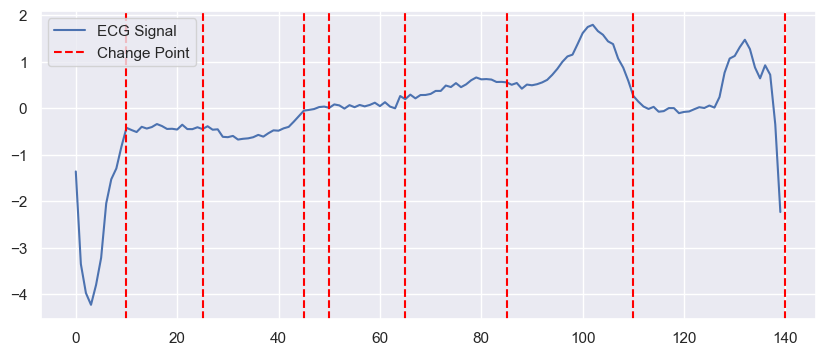

In [208]:
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

# Example signal
signal = ecg_dataset.iloc[20, :-1].values

# Change point detection using different algorithms
algo1 = pelt_segmenter(signal)
algo2 = binseg_segmenter(signal)
algo3 = bottomup_segmenter(signal)

# Combine all detected change points into a single list
all_bkps = np.concatenate([algo1, algo2, algo3])

# Perform hierarchical clustering on the combined list
Z = linkage(all_bkps.reshape(-1, 1), method='ward')

# Determine clusters based on a distance threshold
distance_threshold = find_optimal_threshold(Z)  # Adjust this value as needed
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Select the representative change point from each cluster (e.g., the median)
ensemble_bkps = []
for cluster_id in np.unique(clusters):
    cluster_points = all_bkps[clusters == cluster_id]
    representative_point = np.mean(cluster_points)
    ensemble_bkps.append(representative_point)

# Sort the final change points
ensemble_bkps = np.sort(ensemble_bkps)

# Eredmény ábrázolása
plt.figure(figsize=(10,4))
plt.plot(signal, label="ECG Signal")
for cp in ensemble_bkps:
    plt.axvline(x=cp, color="red", linestyle="--", label="Change Point" if cp == ensemble_bkps[0] else "")
plt.legend()
plt.show()

In [110]:
def PeltBinSegBottomUP_segmenter(ts):
    # Change point detection using different algorithms
    algo1 = pelt_segmenter(ts)
    algo2 = binseg_segmenter(ts)
    algo3 = bottomup_segmenter(ts)

    # Combine all detected change points into a single list
    all_bkps = np.concatenate([algo1, algo2, algo3])

    # Perform hierarchical clustering on the combined list
    Z = linkage(all_bkps.reshape(-1, 1), method='ward')

    # Determine clusters based on a distance threshold
    distance_threshold = find_optimal_threshold(Z, depth=4)  # Adjust this value as needed
    clusters = fcluster(Z, t=distance_threshold, criterion='distance')

    # Select the representative change point from each cluster (e.g., the median)
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    # Sort the final change points
    ensemble_bkps = np.sort(ensemble_bkps)

    return ensemble_bkps

In [39]:
calculate_score(has.iloc[:10], PeltBinSegBottomUP_segmenter)

100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


0.20260512821322382

CLaSP Window BinSeg együttes modellje

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


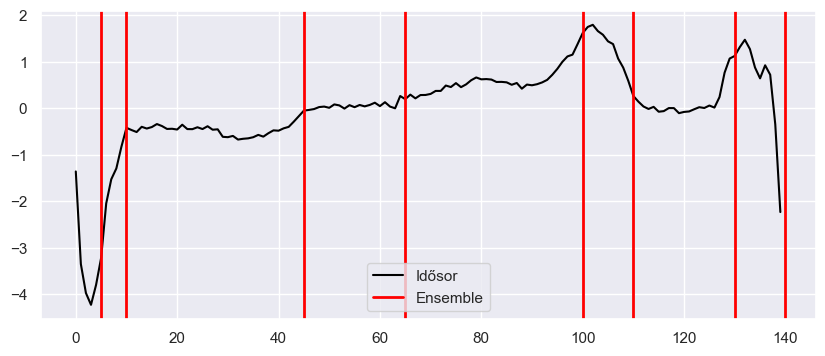

In [111]:
signal = ecg_dataset.iloc[20, :-1].values

# 🔹 ClaSP szegmentáció
breakpoints_clasp = CLaSP_segmenter(signal)

# 🔹 Binary Segmentation (ruptures)
breakpoints_binseg = binseg_segmenter(signal)

# 🔹 Window Segmentation (ruptures)
breakpoints_window = window_segmenter(signal)

all_bkps = np.concatenate([breakpoints_clasp, breakpoints_binseg, breakpoints_window])

# Perform hierarchical clustering on the combined list
Z = linkage(all_bkps.reshape(-1, 1), method='ward')

# Determine clusters based on a distance threshold
distance_threshold = find_optimal_threshold(Z, depth=4)  # Adjust this value as needed
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Select the representative change point from each cluster (e.g., the median)
ensemble_bkps = []
for cluster_id in np.unique(clusters):
    cluster_points = all_bkps[clusters == cluster_id]
    representative_point = np.mean(cluster_points)
    ensemble_bkps.append(representative_point)

# Sort the final change points
ensemble_bkps = np.sort(ensemble_bkps)

# 🔹 Eredmények vizualizálása
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Idősor", color="black")

for bkp in ensemble_bkps:
    plt.axvline(x=bkp, color='red', linestyle='-', linewidth=2, label="Ensemble" if bkp == ensemble_bkps[0] else "")

plt.legend()
plt.show()


In [112]:
def CLaSPWindowBinSeg_segmenter(ts):
    # 🔹 ClaSP szegmentáció
    breakpoints_clasp = CLaSP_segmenter(ts)

    # 🔹 Binary Segmentation (ruptures)
    breakpoints_binseg = binseg_segmenter(ts)

    # 🔹 Window Segmentation (ruptures)
    breakpoints_window = window_segmenter(ts)

    all_bkps = np.concatenate([breakpoints_clasp, breakpoints_binseg, breakpoints_window])

    # Perform hierarchical clustering on the combined list
    Z = linkage(all_bkps.reshape(-1, 1), method='ward')

    # Determine clusters based on a distance threshold
    distance_threshold = find_optimal_threshold(Z, depth=4)
    clusters = fcluster(Z, t=distance_threshold, criterion='distance')

    # Select the representative change point from each cluster (e.g., the median)
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    # Sort the final change points
    ensemble_bkps = np.sort(ensemble_bkps)

    return ensemble_bkps

In [42]:
calculate_score(tssb, CLaSPWindowBinSeg_segmenter)

100%|██████████| 75/75 [00:43<00:00,  1.74it/s]


0.5950348974581374

In [43]:
calculate_score(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


0.8545558856168317

In [ ]:
calculate_score(tssb, PeltBinSegBottomUP_segmenter)

In [205]:
def find_optimal_threshold(Z, max_depth=10):
    max_variation = 0
    best_threshold = None

    for depth in range(1, max_depth + 1):
        inconsistency = inconsistent(Z, depth)
        threshold = np.mean(inconsistency[:, 3]) + np.std(inconsistency[:, 3])
        variation = np.std(inconsistency[:, 3])

        if variation > max_variation:
            max_variation = variation
            best_threshold = threshold
    
    return best_threshold


def ensemble_segmenter(segmenters, ts):
    all_bkps = np.concatenate([seg(ts) for seg in segmenters])
    
    Z = linkage(all_bkps.reshape(-1, 1), method="ward")
    
    distance_threshold = find_optimal_threshold(Z)
    
    clusters = fcluster(Z, t=distance_threshold, criterion="distance")
    
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    return np.sort(ensemble_bkps)

In [209]:
segmenters = [window_segmenter, binseg_segmenter, CLaSP_segmenter]
calculate_weighted_f1(has_for_tcnautoencoder, lambda ts: ensemble_segmenter(segmenters, ts))

 47%|████▋     | 118/250 [01:25<02:09,  1.02it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


0.5643951968344372

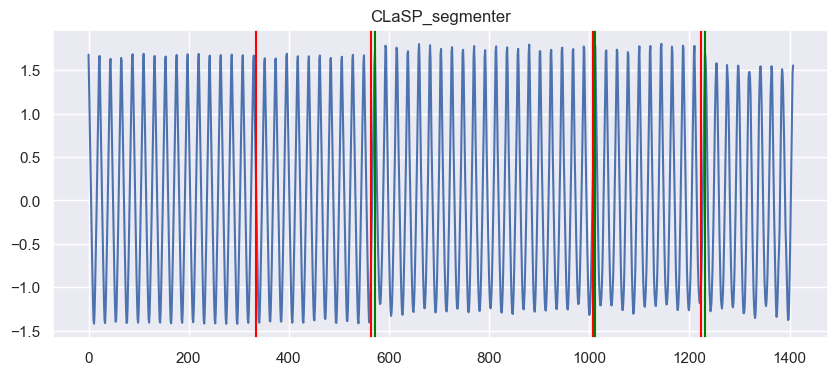

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))


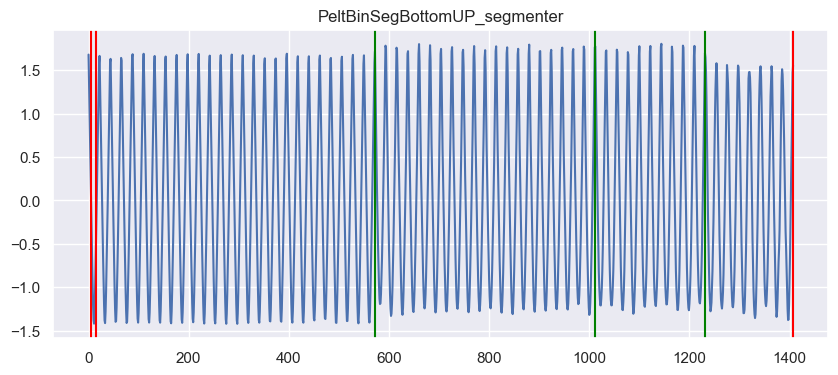

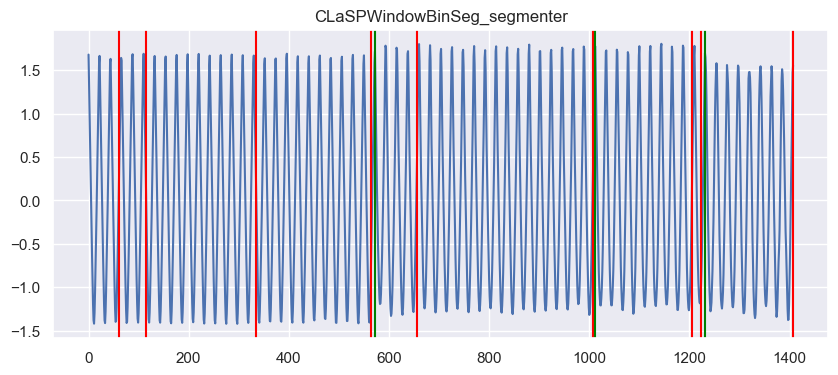

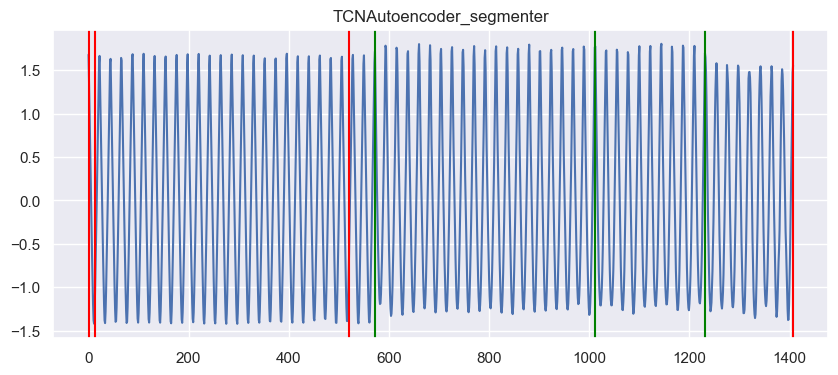

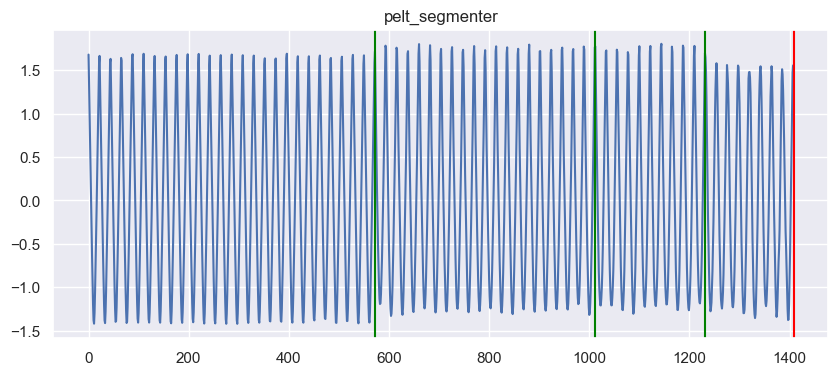

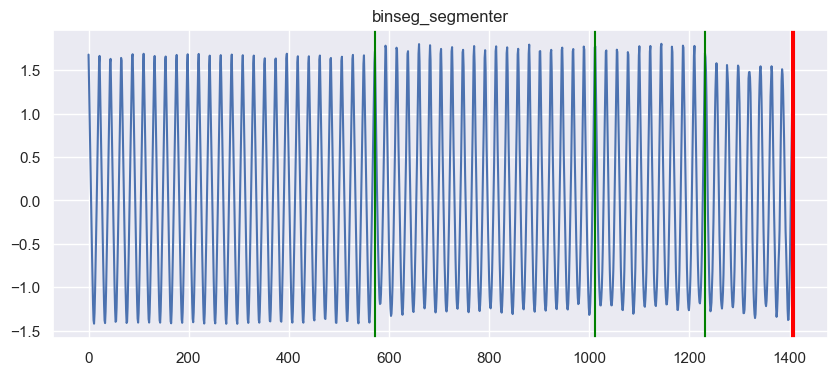

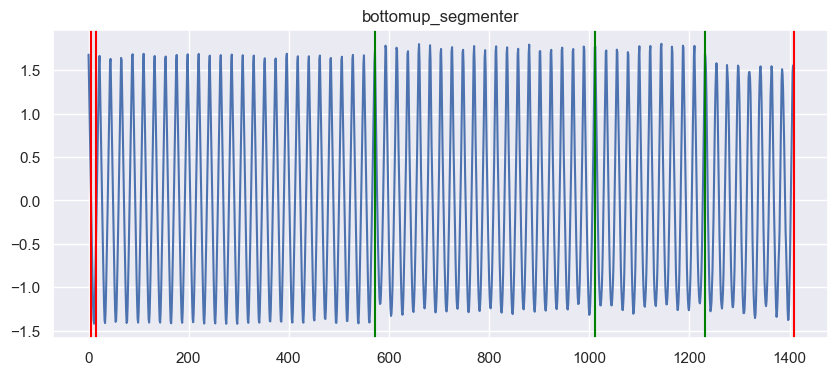

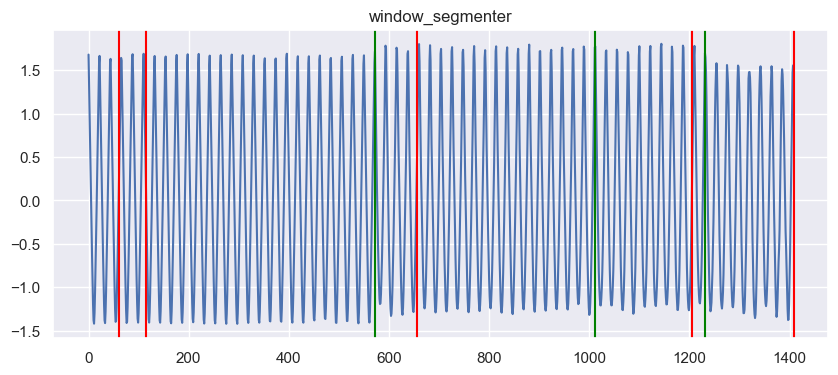

In [108]:
algos = [CLaSP_segmenter, PeltBinSegBottomUP_segmenter, CLaSPWindowBinSeg_segmenter, TCNAutoencoder_segmenter, pelt_segmenter, binseg_segmenter, bottomup_segmenter, window_segmenter]
algo_names = ["CLaSP_segmenter", "PeltBinSegBottomUP_segmenter", "CLaSPWindowBinSeg_segmenter", "TCNAutoencoder_segmenter", "pelt_segmenter", "binseg_segmenter", "bottomup_segmenter", "window_segmenter"]
#ts = ecg_dataset.iloc[20, :-1].values
#ts = np.array(microsoft_stocks_dataset['Open'])
ts = tssb.loc[0, 'time_series']
#ts = has_for_tcnautoencoder.loc[10, 'time_series']

for algo, algo_name in zip(algos, algo_names):
    cps = algo(ts)
    plot_changepoints_on_ts(ts, cps, algo_name, tssb.loc[0, 'change_points'])
    

In [ ]:
calculate_score(tssb, window_segmenter)

100%|██████████| 75/75 [00:02<00:00, 35.55it/s]


0.571954404588221

In [135]:
calculate_score(has_for_tcnautoencoder.iloc[110:140], pelt_segmenter)

100%|██████████| 30/30 [01:11<00:00,  2.37s/it]


0.577730942448072

In [ ]:
calculate_score(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:23<00:00,  3.19it/s]


0.8545558856168317

In [ ]:
calculate_score(has_for_tcnautoencoder, window_segmenter)

100%|██████████| 250/250 [00:12<00:00, 20.73it/s]


0.6019443395510106

In [ ]:
calculate_score(has_for_tcnautoencoder, CLaSP_segmenter)

 47%|████▋     | 118/250 [01:02<01:38,  1.34it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:20<00:00,  1.28s/it]


0.6612691221433274

In [ ]:
calculate_score(has_for_tcnautoencoder, binseg_segmenter)

100%|██████████| 250/250 [00:49<00:00,  5.06it/s]


0.6308197082625985

In [ ]:
calculate_score(has_for_tcnautoencoder, bottomup_segmenter)

100%|██████████| 250/250 [00:42<00:00,  5.83it/s]


0.611074981888805

In [114]:
calculate_score(has_for_tcnautoencoder, CLaSPWindowBinSeg_segmenter)

 47%|████▋     | 118/250 [01:15<01:58,  1.12it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:30<00:00,  1.32s/it]


0.5624671906251018

In [159]:
calculate_weighted_f1(has_for_tcnautoencoder, CLaSP_segmenter)

 47%|████▋     | 118/250 [01:02<01:36,  1.37it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:07<00:00,  1.23s/it]


0.7481608041589447

In [160]:
calculate_weighted_f1(has_for_tcnautoencoder, window_segmenter)

100%|██████████| 250/250 [00:11<00:00, 20.85it/s]


0.7278423613232882

In [161]:
calculate_weighted_f1(has_for_tcnautoencoder, binseg_segmenter)

100%|██████████| 250/250 [00:53<00:00,  4.70it/s]


0.7393095265676439

In [162]:
calculate_weighted_f1(has_for_tcnautoencoder, bottomup_segmenter)

100%|██████████| 250/250 [00:41<00:00,  6.01it/s]


0.7028181818605321

In [163]:
segmenters = [window_segmenter, binseg_segmenter, bottomup_segmenter]
calculate_weighted_f1(has_for_tcnautoencoder, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


0.5571893443801058

In [164]:
calculate_weighted_f1(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:26<00:00,  2.83it/s]


0.8871329196770511

In [165]:
calculate_weighted_f1(tssb, window_segmenter)

100%|██████████| 75/75 [00:02<00:00, 35.16it/s]


0.747081073394465

In [166]:
calculate_weighted_f1(tssb, binseg_segmenter)

100%|██████████| 75/75 [00:19<00:00,  3.89it/s]


0.6694501028895007

In [167]:
calculate_weighted_f1(tssb, bottomup_segmenter)

100%|██████████| 75/75 [00:07<00:00, 10.21it/s]


0.6191587352778435

In [168]:
segmenters = [window_segmenter, binseg_segmenter, bottomup_segmenter]
calculate_weighted_f1(tssb, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


0.3918293274420386

# Ensemble modell az idősor statisztikai mutatói alapján

In [36]:
from sklearn.model_selection import train_test_split

all_in_one_timeseries = pd.concat([tssb, has_for_tcnautoencoder])

train_tssb, test_tssb = train_test_split(tssb, test_size=0.4, random_state=42)
train_has, test_has = train_test_split(has_for_tcnautoencoder, test_size=0.4, random_state=42)
train_all, test_all = train_test_split(all_in_one_timeseries, test_size=0.4, random_state=42)

In [37]:
from scipy.stats import linregress, median_abs_deviation
from sklearn.linear_model import TheilSenRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

def compute_features(ts):
    x = np.arange(len(ts))

    slope_lr, _, _, _, _ = linregress(x, ts)

    rolling_std = pd.Series(ts).rolling(window=10, min_periods=5).std().mean()

    autocorr = acf(ts, nlags=1)[1]

    length = len(ts)

    #mean_abs_change = np.mean(np.abs(np.diff(ts)))

    coefficient_of_variation = np.std(ts) / np.mean(ts) if np.mean(ts) != 0 else 0

    return slope_lr, rolling_std, autocorr, length, coefficient_of_variation


In [38]:
features = []
for ts in tqdm(train_has['time_series']):
    trend, volatility, autocorr, length, cv = compute_features(ts)
    features.append([autocorr, length, cv])

features_df = pd.DataFrame(features, columns=[
    "autocorr", "length", "cv"
])

100%|██████████| 150/150 [00:00<00:00, 1505.58it/s]


In [39]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

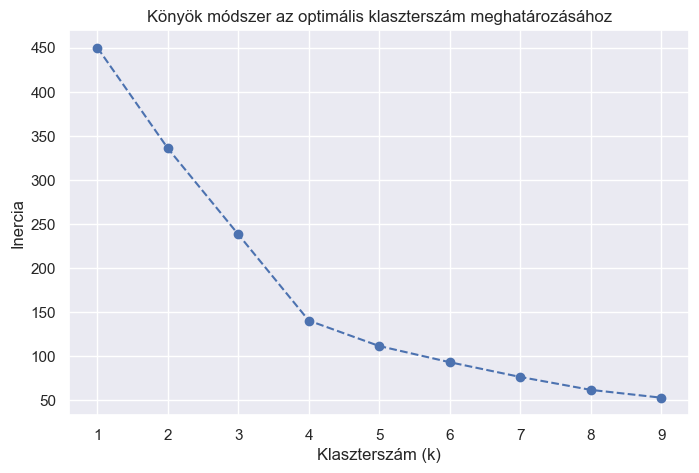

In [40]:
inertia = []
k_values = range(1, 10)  # Klaszterszámokat 1-től 10-ig vizsgáljuk

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--", color="b")
plt.xlabel("Klaszterszám (k)")
plt.ylabel("Inercia")
plt.title("Könyök módszer az optimális klaszterszám meghatározásához")
plt.show()

In [41]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features_df["Cluster"] = kmeans.fit_predict(features_scaled)

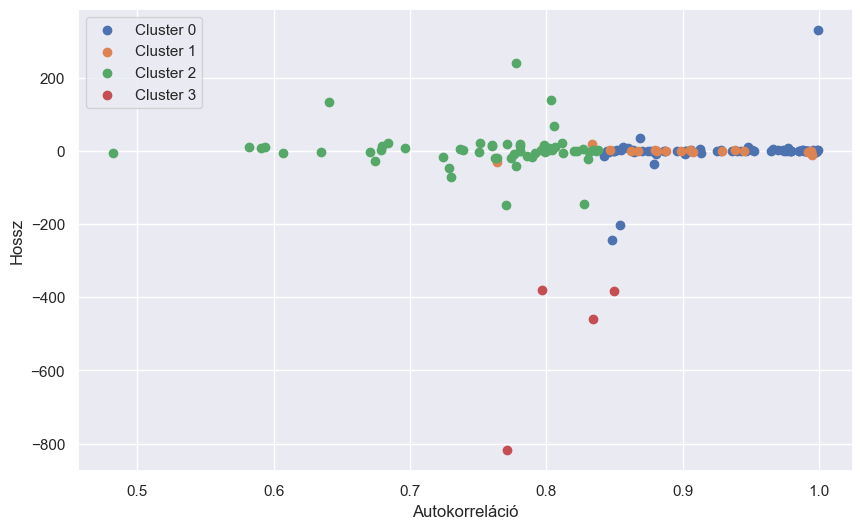

In [105]:
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    subset = features_df[features_df["Cluster"] == cluster]
    plt.scatter(subset["autocorr"], subset["cv"], label=f"Cluster {cluster}")
    plt.xlabel("Autokorreláció")
    plt.ylabel("Hossz")
    plt.legend()
#plt.axhline(y=17000, color='r', linestyle='--', label="Hossz küszöb")
plt.show()

In [43]:
#train_tssb['cluster'] = features_df['Cluster'].values
train_has['cluster'] = features_df['Cluster'].values
#all_in_one_timeseries['cluster'] = features_df['Cluster'].values

In [44]:
# train_tssb_cluster0 = train_tssb[train_tssb['cluster'] == 0].copy().reset_index(drop=True)
# train_tssb_cluster1 = train_tssb[train_tssb['cluster'] == 1].copy().reset_index(drop=True)
# train_tssb_cluster2 = train_tssb[train_tssb['cluster'] == 2].copy().reset_index(drop=True)

train_has_cluster0 = train_has[train_has['cluster'] == 0].copy().reset_index(drop=True)
train_has_cluster1 = train_has[train_has['cluster'] == 1].copy().reset_index(drop=True)
train_has_cluster2 = train_has[train_has['cluster'] == 2].copy().reset_index(drop=True)
train_has_cluster3 = train_has[train_has['cluster'] == 3].copy().reset_index(drop=True)

# all_in_one_timeseries_cluster0 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 0].copy().reset_index(drop=True)
# all_in_one_timeseries_cluster1 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 1].copy().reset_index(drop=True)
# all_in_one_timeseries_cluster2 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 2].copy().reset_index(drop=True)

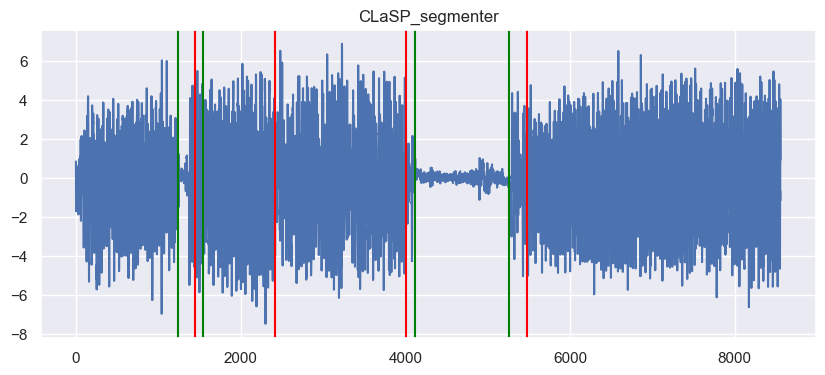

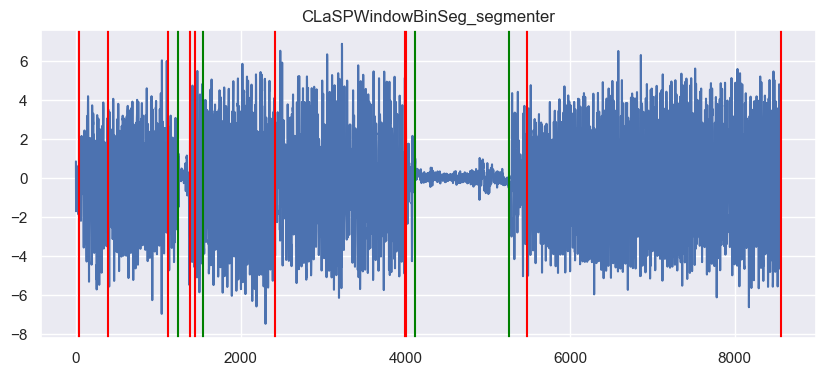

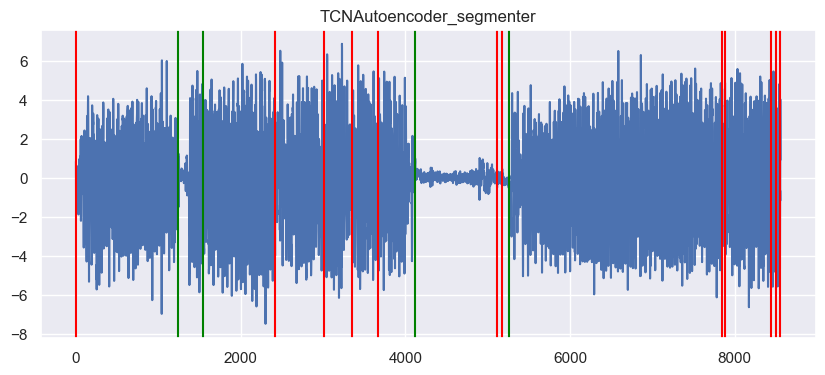

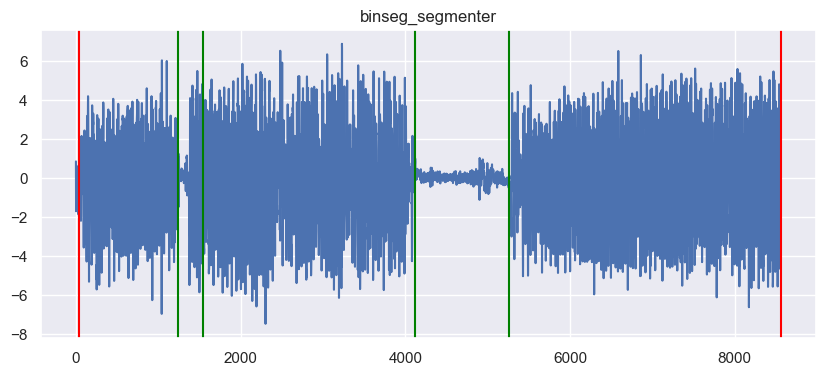

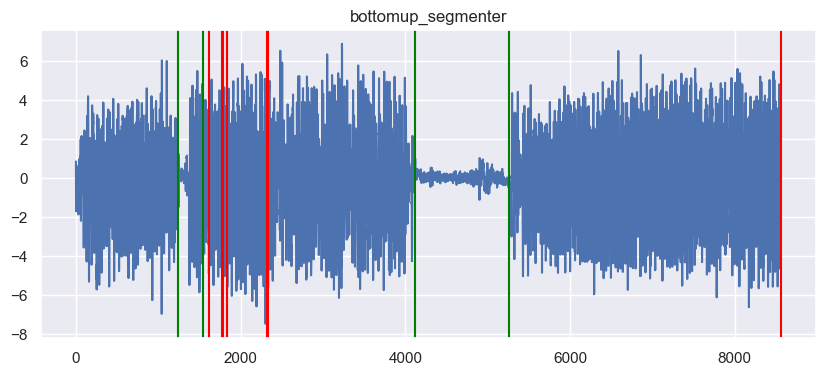

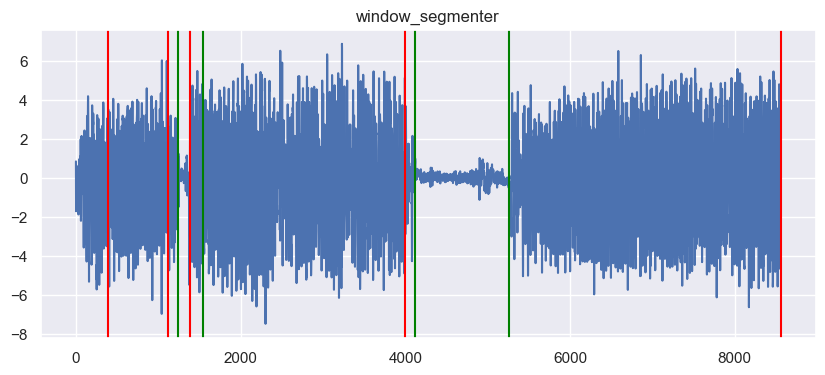

In [115]:
algos = [CLaSP_segmenter, CLaSPWindowBinSeg_segmenter, TCNAutoencoder_segmenter, binseg_segmenter, bottomup_segmenter, window_segmenter]
algo_names = ["CLaSP_segmenter", "CLaSPWindowBinSeg_segmenter", "TCNAutoencoder_segmenter", "binseg_segmenter", "bottomup_segmenter", "window_segmenter"]



#ts = train_tssb_cluster0.loc[1, 'time_series']
#ts =train_tssb_cluster1.loc[0, 'time_series']
#ts = train_tssb_cluster2.loc[0, 'time_series']

#ts = train_has_cluster0.loc[1, 'time_series']
#ts = train_has_cluster1.loc[2, 'time_series']
#ts = train_has_cluster2.loc[0, 'time_series']
ts = train_has_cluster3.loc[1, 'time_series']

#ts = all_in_one_timeseries_cluster0.loc[0, 'time_series']
#ts = all_in_one_timeseries_cluster1.loc[3, 'time_series']
#ts = all_in_one_timeseries_cluster2.loc[0, 'time_series']

for algo, algo_name in zip(algos, algo_names):
    cps = algo(ts)
    plot_changepoints_on_ts(ts, cps, algo_name, train_has_cluster3.loc[1, 'change_points'])

In [159]:
calculate_score(train_has_cluster3, CLaSP_segmenter)

100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


0.725677934946752

In [117]:
calculate_score(train_has_cluster3, CLaSPWindowBinSeg_segmenter)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


0.6151544396536869

In [160]:
calculate_score(train_has_cluster3, TCNAutoencoder_segmenter)

100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


0.49760810639324604

In [123]:
calculate_score(tssb, binseg_segmenter)

100%|██████████| 75/75 [00:18<00:00,  3.97it/s]


0.39317200625390214

In [125]:
calculate_score(tssb, bottomup_segmenter)

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


0.514461438532852

In [127]:
calculate_score(has_for_tcnautoencoder, window_segmenter)  

100%|██████████| 250/250 [00:11<00:00, 21.97it/s]


0.6019443395510106

In [124]:
algos = [bottomup_segmenter, binseg_segmenter]
calculate_score(tssb, lambda ts: ensemble_segmenter(algos, ts))

100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


0.49765211507922763

In [86]:
segmenters = [bottomup_segmenter, binseg_segmenter, window_segmenter]
calculate_score(train_has_cluster1, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 18/18 [00:28<00:00,  1.58s/it]


0.5303957273449444

In [45]:
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)


boundaries = {}
for i in range(optimal_k - 1):
    for j in range(i + 1, optimal_k):
        midpoint = (centroids[i] + centroids[j]) / 2
        boundaries[f"Boundary {i}-{j}"] = midpoint

boundary_df = pd.DataFrame(boundaries).T
boundary_df.columns = features_df.columns[:-1]

In [46]:
boundary_df

,autocorr,length,cv
Boundary 0-1,0.917403,15455.141628,-1.596701
Boundary 0-2,0.842511,5215.758587,0.629283
Boundary 0-3,0.873061,6635.697183,-255.923073
Boundary 1-2,0.826905,15807.505848,0.807668
Boundary 1-3,0.857456,17227.444444,-255.744689
Boundary 2-3,0.782563,6988.061404,-253.518705


In [47]:
def statistical_ensemble_segmenter(ts):
    slope_lr, rolling_std, autocorr, length = compute_features(ts)

    if length > 17000:
        return binseg_segmenter(ts)
    else:
        return CLaSP_segmenter(ts)

In [69]:
calculate_score(all_in_one_timeseries, statistical_ensemble_segmenter)

 59%|█████▉    | 193/325 [01:17<01:42,  1.29it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 325/325 [02:10<00:00,  2.49it/s]


0.7070843777966405

In [70]:
calculate_score(all_in_one_timeseries, CLaSP_segmenter)

 59%|█████▉    | 193/325 [01:29<01:37,  1.36it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 325/325 [05:38<00:00,  1.04s/it]


0.7058737598679826

# Végleges algoritmus

In [202]:
def model_preprocessing(train_set):
    features = []
    for ts in tqdm(train_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    features_df["Cluster"] = kmeans.fit_predict(features_scaled)

    train_set['cluster'] = features_df['Cluster'].values

    train_cluster0 = train_set[train_set['cluster'] == 0].copy().reset_index(drop=True)
    train_cluster1 = train_set[train_set['cluster'] == 1].copy().reset_index(drop=True)
    train_cluster2 = train_set[train_set['cluster'] == 2].copy().reset_index(drop=True)
    train_cluster3 = train_set[train_set['cluster'] == 3].copy().reset_index(drop=True)

    clustered_data = [train_cluster0, train_cluster1, train_cluster2, train_cluster3]

    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_k):
        subset = features_df[features_df["Cluster"] == cluster]
        plt.scatter(subset["autocorr"], subset["length"], label=f"Cluster {cluster}")
        plt.xlabel("Autokorreláció")
        plt.ylabel("Hossz")
        plt.legend()
    plt.show()

    return clustered_data, kmeans, scaler        

In [193]:
def calc_models_for_clusters(clustered_data):
    algos = [window_segmenter, binseg_segmenter, bottomup_segmenter, TCNAutoencoder_segmenter]

    algo_for_cluster = {}
    for train_cluster in clustered_data:
        scores = []
        for algo in algos:
            score = calculate_score(train_cluster, algo)
            scores.append(score)
        best_algo = algos[np.argmax(scores)]
        algo_for_cluster[train_cluster['cluster'].iloc[0]] = best_algo

    return algo_for_cluster

In [199]:
def my_ensemble(test_set, kmeans, scaler, algo_for_cluster):
    features = []
    for ts in tqdm(test_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    features_scaled = scaler.transform(features_df)

    test_set['cluster'] = kmeans.predict(features_scaled)

    test_cluster0 = test_set[test_set['cluster'] == 0].copy().reset_index(drop=True)
    test_cluster1 = test_set[test_set['cluster'] == 1].copy().reset_index(drop=True)
    test_cluster2 = test_set[test_set['cluster'] == 2].copy().reset_index(drop=True)
    test_cluster3 = test_set[test_set['cluster'] == 3].copy().reset_index(drop=True)

    test_clustered_data = [test_cluster0, test_cluster1, test_cluster2, test_cluster3]

    scores = []
    for test_cluster in test_clustered_data:
        if test_cluster.empty:
            continue
        algo = algo_for_cluster[test_cluster['cluster'].iloc[0]]
        score = calculate_score(test_cluster, algo)
        scores.append(score)
            

    return np.mean(scores)
    

HAS-on eredmény

100%|██████████| 150/150 [00:00<00:00, 1100.65it/s]


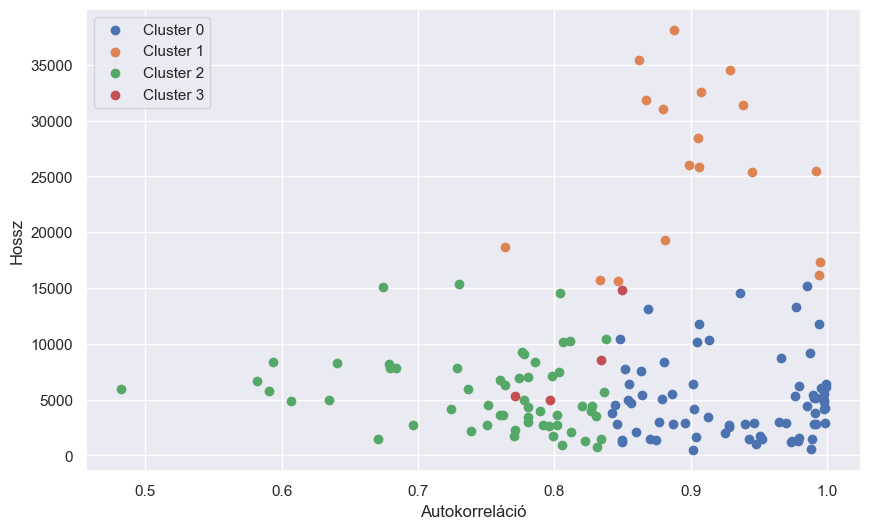

In [203]:
clustered_data, kmeans, scaler  = model_preprocessing(train_has)

In [197]:
algo_for_cluster = calc_models_for_clusters(clustered_data)

100%|██████████| 4/4 [00:13<00:00,  3.34s/it]


In [200]:
accuracy_on_test = my_ensemble(test_has, kmeans, scaler, algo_for_cluster)
accuracy_on_test

100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


np.float64(0.6407656424146201)

In [201]:
algo_for_cluster

{np.int32(0): <function __main__.binseg_segmenter(ts, model='l2')>,
 np.int32(1): <function __main__.bottomup_segmenter(ts, model='l2')>,
 np.int32(2): <function __main__.binseg_segmenter(ts, model='l2')>,
 np.int32(3): <function __main__.window_segmenter(ts, model='l2', width=None)>}

In [109]:
calculate_score(test_has, CLaSP_segmenter)

100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


0.645852179198418

TSSB-n eredmény

In [119]:
clustered_data, kmeans, scaler  = model_preprocessing(train_tssb)

100%|██████████| 45/45 [00:00<00:00, 1100.46it/s]


In [120]:
algo_for_cluster = calc_models_for_clusters(clustered_data)

100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


In [121]:
accuracy_on_test = my_ensemble(test_tssb, kmeans, scaler, algo_for_cluster)
accuracy_on_test

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


np.float64(0.9031441647425454)

# TODO
# Végleges algoritmus F1 score-ral